# MNIST Evaluation

## Common functions

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from tqdm import tqdm
import matplotlib.pyplot as plt

def make_linear_kernel():
    """
    线性核：k(x, y) = x · y^T
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return X.dot(Y.T)
    return kernel

def make_polynomial_kernel(degree: int = 3, gamma: float = None, coef0: float = 1.0):
    """
    多项式核：k(x, y) = (gamma * x·y^T + coef0)^degree
    如果未指定 gamma，则默认 gamma = 1 / dim。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        nonlocal gamma
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        return (gamma * X.dot(Y.T) + coef0) ** degree
    return kernel

def make_sigmoid_kernel(alpha: float = 0.01, coef0: float = 0.0):
    """
    Sigmoid 核（双曲正切核，也叫神经网络核）：k(x, y) = tanh(alpha * x·y^T + coef0)
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return np.tanh(alpha * X.dot(Y.T) + coef0)
    return kernel

def make_laplacian_kernel(sigma: float = 1.0):
    """
    拉普拉斯核（基于 L1 距离）：k(x, y) = exp( -||x - y||_1 / sigma )
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 计算成对的 L1 距离矩阵
        abs_diff = np.abs(X[:, None, :] - Y[None, :, :])
        dist = np.sum(abs_diff, axis=2)
        return np.exp(-dist / sigma)
    return kernel

# 可选：Matern 核（ν = 3/2 形式示例）
def make_matern32_kernel(length_scale: float = 1.0):
    """
    Matern-3/2 核：k(r) = (1 + sqrt(3) r / l) * exp(-sqrt(3) r / l)
    其中 r = ||x - y||_2，l = length_scale。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 计算成对的 L2 距离矩阵
        sq_dist = np.sum((X[:, None, :] - Y[None, :, :])**2, axis=2)
        r = np.sqrt(sq_dist)
        factor = np.sqrt(3) * r / length_scale
        return (1 + factor) * np.exp(-factor)
    return kernel

# 1. RBF‐kernel 工厂函数：指定 sigma 后返回一个 kernel(X, Y) 函数
def make_rbf_kernel(sigma: float):
    """
    返回一个 Gaussian RBF kernel 函数，固定带宽 sigma。
    kernel(X, Y) 接受形状为 (n, d) 和 (m, d) 的数组，返回 (n, m) 的相似度矩阵。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 广播计算平方距离
        # X[:, None, :] 变为 (n,1,d)，Y[None, :, :] 变为 (1,m,d)
        sq_dist = np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2)
        return np.exp(-sq_dist / (2 * sigma ** 2))
    return kernel

# 2. 计算 MMD² 的函数，只需传入 kernel
def compute_mmd(X: np.ndarray, Y: np.ndarray, kernel) -> float:
    """
    计算两个样本 X, Y 之间的 MMD²（无偏估计量）。
    """
    m = X.shape[0]
    n = Y.shape[0]

    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)

    mmd2 = (np.sum(K_XX) / (m * m)
            + np.sum(K_YY) / (n * n)
            - 2 * np.sum(K_XY) / (m * n))
    return mmd2


# 3. permutation_test 接受 kernel，自动利用它生成 null 分布
def permutation_test(
    X: np.ndarray,
    Y: np.ndarray,
    kernel,
    num_permutations: int = 500
) -> float:
    """
    对 H0: P=Q 进行置换检验，返回 p-value。
    """
    observed_mmd = compute_mmd(X, Y, kernel)
    combined = np.vstack((X, Y))
    m = X.shape[0]

    permuted_stats = []
    for _ in range(num_permutations):
        idx = np.random.permutation(combined.shape[0])
        Xp = combined[idx[:m]]
        Yp = combined[idx[m:]]
        permuted_stats.append(compute_mmd(Xp, Yp, kernel))
    permuted_stats = np.array(permuted_stats)
    p_value = np.mean(permuted_stats >= observed_mmd)
    return p_value, observed_mmd, permuted_stats



# 4. 通用计算 MNIST 样本对 p 值矩阵
def compute_mnist_matrix(sample_size: int, num_permutations: int, kernel) -> np.ndarray:
    """
    分别从 digits 0-9 中随机抽取 sample_size 样本作为 X 与 Y，计算所有数字对 (i,j) 的 p 值矩阵。
    显示计算进度。
    """
    digits = load_digits()
    X_all, y_all = digits.data, digits.target
    p_mat = np.zeros((10, 10))
    for i in tqdm(range(10), desc=f'Outer loop (digit i)'):
        Xi = X_all[y_all == i]
        for j in tqdm(range(10), desc=f'Inner loop (digit j)', leave=False):
            if i == j:
                idx_all = np.random.choice(len(Xi), sample_size*2, replace=False)
                X = Xi[idx_all[:sample_size]]
                Y = Xi[idx_all[sample_size:]]
            else:
                Xj = X_all[y_all == j]
                idx_i = np.random.choice(len(Xi), sample_size, replace=False)
                idx_j = np.random.choice(len(Xj), sample_size, replace=False)
                X = Xi[idx_i]
                Y = Xj[idx_j]
            p_mat[i, j], observed_mmd, permuted_stats = permutation_test(X, Y, kernel, num_permutations)
    return p_mat


def plot_p_matrix(p_matrix: np.ndarray, title: str = "Permutation Test p-values") -> None:
    """
    绘制 p 值热力图，支持单次和多次实验结果。
    - 单次实验：p_matrix.shape = (10,10)，在每个格子显示“均值”。
    - 多次实验：p_matrix.shape = (T,10,10)，在每个格子显示“mean\n±std”。
    
    参数:
        p_matrix (np.ndarray): shape=(10,10) 或 (T,10,10) 的 p 值矩阵或矩阵列表
        title (str): 图表标题
    返回:
        fig, ax: Matplotlib Figure 和 Axes 对象
    """
    # 判断输入维度
    p_arr = np.array(p_matrix)
    print(f"p_arr.shape: {p_arr.shape}")
    if p_arr.ndim == 2:
        # 单次实验
        mean_mat = p_arr
        std_mat = None
    elif p_arr.ndim == 3:
        # 多次实验
        mean_mat = p_arr.mean(axis=0)
        std_mat = p_arr.std(axis=0)
    else:
        raise ValueError("p_matrix must have shape (10,10) or (T,10,10)")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(mean_mat, interpolation='nearest', vmin=0, vmax=1)
    
    # 在每个格子上标注
    for i in range(mean_mat.shape[0]):
        for j in range(mean_mat.shape[1]):
            m = mean_mat[i, j]
            if std_mat is not None:
                s = std_mat[i, j]
                text = f"{m:.2f}\n±{s:.2f}"
            else:
                text = f"{m:.2f}"
            # 文本颜色根据 mean 值自动设定
            color = 'white' if m < 0.5 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=color, fontsize=8)

    # 色条
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Mean p-value')
    # 坐标标签
    ax.set_xticks(np.arange(mean_mat.shape[1]))
    ax.set_yticks(np.arange(mean_mat.shape[0]))
    ax.set_xlabel('Digit Y')
    ax.set_ylabel('Digit X')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax


MAKE_KERNEL_FACTORIES = {
    'linear': make_linear_kernel,
    'polynomial': make_polynomial_kernel,
    'sigmoid': make_sigmoid_kernel,
    'laplacian': make_laplacian_kernel,
    'matern32': make_matern32_kernel,
    'rbf': make_rbf_kernel
}


## Eval sigma

In [ ]:
def summarize_sigmas(sigmas, sample_size, num_permutations, compute_mnist_matrix, alpha=0.05):
    type1 = []
    power  = []
    p_mats = []
    for sigma in sigmas:
        kernel = make_rbf_kernel(sigma)
        p_mat = compute_mnist_matrix(sample_size, num_permutations, kernel)

        # 对角线：同分布情况，第一类错误率
        diag_p = p_mat[np.arange(10), np.arange(10)]
        type1.append(np.mean(diag_p < alpha))

        # 非对角线：异分布情况，功效
        off_p = p_mat[~np.eye(10, dtype=bool)]
        power.append(np.mean(off_p < alpha))

        p_mats.append(p_mat)

    return np.array(type1), np.array(power), p_mats

# 参数
sigmas = [0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]
# sigmas = [5.0]
sample_size = 50
num_permutations = 300

# 计算
type1_all, power_all, p_mats_all = summarize_sigmas(sigmas, sample_size, num_permutations, compute_mnist_matrix)


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


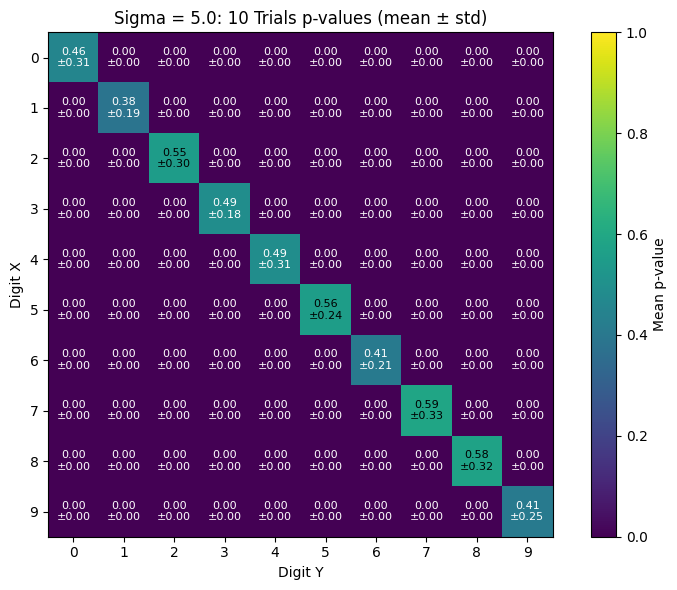

In [ ]:
the_sigma = 5.0

# sigmas, type1, power, p_mats 已由 summarize_sigmas 返回
n_trials = len(p_mats_all)
# 找到 sigma=the_sigma 在 sigmas 列表中的索引
idx = sigmas.index(the_sigma)

# 提取 10 次试验中对应 sigma=the_sigma 的 p_matrix
p_list_sigma = [p_mats_all[t][idx] for t in range(n_trials)]
# 堆叠为形状 (10,10,10) 的数组
p_array_sigma = np.stack(p_list_sigma, axis=0)

# 绘制热力图
fig, ax = plot_p_matrix(
    p_array_sigma,
    title="Sigma = 5.0: 10 Trials p-values (mean ± std)"
)
plt.show()

In [ ]:

def summarize_sigmas(
    sigmas,
    sample_size,
    num_permutations,
    compute_mnist_matrix,
    make_rbf_kernel,
    n_trials=1,
    alpha=0.05
):
    """
    对不同 σ 多次试验并返回每次试验的 Type I Error 和 Power，以及所有的 p 矩阵。
    - sigmas: list of σ
    - n_trials: 重复试验次数
    返回:
      type1: shape (n_trials, len(sigmas))
      power: shape (n_trials, len(sigmas))
      p_mats: list of list, p_mats[t][i] 对应第 t 次试验第 i 个 σ 的 p 矩阵
    """
    sigmas = list(sigmas)
    T = n_trials
    S = len(sigmas)
    type1 = np.zeros((T, S))
    power = np.zeros((T, S))
    p_mats = [[None] * S for _ in range(T)]

    for t in range(T):
        for i, sigma in enumerate(sigmas):
            print(f"Trial {t}, σ = {sigma:.2f}")
            kernel = make_rbf_kernel(sigma)
            p_mat = compute_mnist_matrix(sample_size, num_permutations, kernel)
            # 同分布 → Type I Error
            diag_p = p_mat[np.arange(10), np.arange(10)]
            type1[t, i] = np.mean(diag_p < alpha)
            # 异分布 → Power
            off_p = p_mat[~np.eye(10, dtype=bool)]
            power[t, i] = np.mean(off_p < alpha)
            p_mats[t][i] = p_mat

    return type1, power, p_mats

def plot_power_type1(sigmas, power, type1, alpha=0.05, xticks=None):
    """
    如果 power 和 type1 是一维，则按单次试验画线；
    如果是二维 (n_trials, len(sigmas))，则画均值曲线并填充 ±1 std 带。
    """
    sigmas = np.array(sigmas)
    power = np.array(power)
    type1 = np.array(type1)
    multi = (power.ndim == 2 and type1.ndim == 2)

    if multi:
        p_mean = power.mean(axis=0)
        p_std = power.std(axis=0)
        t_mean = type1.mean(axis=0)
        t_std = type1.std(axis=0)
    else:
        p_mean = power
        p_std = None
        t_mean = type1
        t_std = None

    fig, ax = plt.subplots(figsize=(8, 5))
    # Power
    ax.plot(sigmas, p_mean, 'o-', label='Power', color='C0', markersize=6, linewidth=2)
    if multi:
        ax.fill_between(sigmas, p_mean - p_std, p_mean + p_std, color='C0', alpha=0.3)
    # Type I Error
    ax.plot(sigmas, t_mean, 's--', label='Type I Error', color='C1', markersize=6, linewidth=2)
    if multi:
        ax.fill_between(sigmas, t_mean - t_std, t_mean + t_std, color='C1', alpha=0.3)

    # 对数横轴 & 刻度
    ax.set_xscale('log')
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(sigmas)
    ax.set_xticklabels([str(s) for s in sigmas], fontsize=12)

    # 显著性水平线 & 阴影
    ax.axhline(alpha, color='gray', linestyle=':', linewidth=1.5, label=f'α = {alpha}')
    ax.fill_between(sigmas, 0, alpha, color='gray', alpha=0.1)

    # 网格
    ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.3)
    ax.minorticks_on()

    # 标签 & 标题
    ax.set_xlabel('RBF Kernel σ', fontsize=14)
    ax.set_ylabel('Rate', fontsize=14)
    ax.set_title('Power & Type I Error vs. Kernel Bandwidth', fontsize=16)

    # 图例
    ax.legend(loc='upper left', fontsize=12, title='Metric', title_fontsize=13)

    # # 注释最佳 σ
    # best = sigmas[np.argmax(p_mean)]
    # ax.annotate('Best σ', xy=(best, p_mean.max()),
    #             xytext=(best, p_mean.max() - 0.15),
    #             arrowprops=dict(arrowstyle='->'), fontsize=12)

    plt.tight_layout()
    return fig, ax

In [48]:
sigmas = [0.2, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
sample_size = 50
num_permutations = 300
# 做 10 次试验，得到 shape=(5,8) 的 power 和 type1
type1_mat, power_mat, p_mats = summarize_sigmas(
    sigmas, sample_size, num_permutations, compute_mnist_matrix, make_rbf_kernel, n_trials=10, alpha=0.05
)


Trial 0, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Trial 0, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


Trial 0, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Trial 0, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


Trial 0, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


Trial 0, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


Trial 0, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Trial 0, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 0, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Trial 0, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Trial 0, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Trial 0, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Trial 0, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


Trial 1, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


Trial 1, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Trial 1, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


Trial 1, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


Trial 1, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Trial 1, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Trial 1, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 1, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Trial 1, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Trial 1, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


Trial 1, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Trial 1, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


Trial 1, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Trial 2, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Trial 2, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Trial 2, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


Trial 2, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Trial 2, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


Trial 2, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 2, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 2, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 2, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Trial 2, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Trial 2, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 2, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 2, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


Trial 3, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


Trial 3, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Trial 3, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Trial 3, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.10s/it]


Trial 3, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Trial 3, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 3, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 3, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 3, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 3, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 3, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 3, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Trial 3, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 4, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


Trial 4, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Trial 4, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Trial 4, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


Trial 4, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


Trial 4, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Trial 4, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 4, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 4, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


Trial 4, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


Trial 4, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Trial 4, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 4, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


Trial 5, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


Trial 5, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Trial 5, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Trial 5, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


Trial 5, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Trial 5, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 5, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 5, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Trial 5, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 5, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


Trial 5, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Trial 5, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 5, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 6, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


Trial 6, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


Trial 6, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Trial 6, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Trial 6, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Trial 6, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Trial 6, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Trial 6, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 6, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


Trial 6, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 6, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


Trial 6, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 6, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


Trial 7, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


Trial 7, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


Trial 7, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


Trial 7, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Trial 7, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


Trial 7, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


Trial 7, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 7, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 7, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


Trial 7, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


Trial 7, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 7, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 7, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 8, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Trial 8, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


Trial 8, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Trial 8, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Trial 8, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


Trial 8, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


Trial 8, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 8, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


Trial 8, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


Trial 8, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


Trial 8, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


Trial 8, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Trial 8, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Trial 9, σ = 0.20


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


Trial 9, σ = 0.50


Outer loop (digit i): 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


Trial 9, σ = 1.00


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


Trial 9, σ = 1.20


Outer loop (digit i): 100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


Trial 9, σ = 1.40


Outer loop (digit i): 100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


Trial 9, σ = 1.60


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


Trial 9, σ = 1.80


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


Trial 9, σ = 2.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Trial 9, σ = 5.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


Trial 9, σ = 10.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


Trial 9, σ = 20.00


Outer loop (digit i): 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Trial 9, σ = 50.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


Trial 9, σ = 100.00


Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


In [4]:
xticks = [0.2, 0.5, 1.0, 1,5, 2.0, 5.0, 10.0, 20.0, 50.0]
fig, ax = plot_power_type1(sigmas, power_mat, type1_mat, alpha=0.05, xticks=xticks)
plt.show()

NameError: name 'plot_power_type1' is not defined

## Type 1 error control in noise and blur

In [ ]:
from scipy.ndimage import gaussian_filter
# === 数据变换函数 ===
def add_noise(X: np.ndarray, noise_std: float):
    noisy = X + np.random.normal(scale=noise_std, size=X.shape)
    return np.clip(noisy, 0, 16)

def blur_images(X: np.ndarray, blur_sigma: float):
    imgs = X.reshape(-1, 8, 8)
    blurred = np.array([gaussian_filter(img, sigma=blur_sigma) for img in imgs])
    return blurred.reshape(-1, 64)

def systematic_type1_experiments(
    sample_size: int,
    sigmas: list,
    num_permutations: int,
    noise_stds: list,
    blur_sigmas: list,
    n_trials: int = 50,
    alpha: float = 0.05
):
    digits = load_digits()
    X_all = digits.data  # shape (1797, 64)
    y_all = digits.target
    results_noise = np.zeros((len(noise_stds), len(sigmas)))
    results_blur  = np.zeros((len(blur_sigmas), len(sigmas)))
    
    # 对每个噪声水平
    for i, std in enumerate(noise_stds):
        for j, sigma in enumerate(sigmas):
            kernel = make_rbf_kernel(sigma)
            count_reject = 0
            total = 0
            for d in range(10):
                Xd = X_all[y_all == d]
                for t in range(n_trials):
                    idx = np.random.choice(len(Xd), sample_size, replace=False)
                    P = Xd[idx]
                    Q = add_noise(P, std)
                    pval, _, _ = permutation_test(P, Q, kernel, num_permutations)
                    if pval < alpha:
                        count_reject += 1
                    total += 1
            results_noise[i, j] = count_reject / total

    # 对每个模糊水平
    for i, bs in enumerate(blur_sigmas):
        for j, sigma in enumerate(sigmas):
            kernel = make_rbf_kernel(sigma)
            count_reject = 0
            total = 0
            for d in range(10):
                Xd = X_all[y_all == d]
                for t in range(n_trials):
                    idx = np.random.choice(len(Xd), sample_size, replace=False)
                    P = Xd[idx]
                    Q = blur_images(P, bs)
                    pval, _, _ = permutation_test(P, Q, kernel, num_permutations)
                    if pval < alpha:
                        count_reject += 1
                    total += 1
            results_blur[i, j] = count_reject / total

    return results_noise, results_blur

In [61]:
def systematic_type1_experiments(
    sample_size: int,
    sigmas: list,
    num_permutations: int,
    noise_stds: list,
    blur_sigmas: list,
    n_trials: int = 50,
    alpha: float = 0.05
):
    digits = load_digits()
    X_all = digits.data  # shape (1797, 64)
    y_all = digits.target
    results_noise = np.zeros((len(noise_stds), len(sigmas)))
    results_blur  = np.zeros((len(blur_sigmas), len(sigmas)))
    
    # 对每个噪声水平
    for i, std in tqdm(enumerate(noise_stds), desc='Noise levels', total=len(noise_stds)):
        for j, sigma in enumerate(sigmas):
            kernel = make_rbf_kernel(sigma)
            count_reject = 0
            total = 0
            for d in range(10):
                Xd = X_all[y_all == d]
                for t in range(n_trials):
                    idx = np.random.choice(len(Xd), sample_size, replace=False)
                    P = Xd[idx]
                    Q = add_noise(P, std)
                    pval, _, _ = permutation_test(P, Q, kernel, num_permutations)
                    if pval < alpha:
                        count_reject += 1
                    total += 1
            results_noise[i, j] = count_reject / total

    # 对每个模糊水平
    for i, bs in tqdm(enumerate(blur_sigmas), desc='Blur levels', total=len(blur_sigmas)):
        for j, sigma in enumerate(sigmas):
            kernel = make_rbf_kernel(sigma)
            count_reject = 0
            total = 0
            for d in range(10):
                Xd = X_all[y_all == d]
                for t in range(n_trials):
                    idx = np.random.choice(len(Xd), sample_size, replace=False)
                    P = Xd[idx]
                    Q = blur_images(P, bs)
                    pval, _, _ = permutation_test(P, Q, kernel, num_permutations)
                    if pval < alpha:
                        count_reject += 1
                    total += 1
            results_blur[i, j] = count_reject / total

    return results_noise, results_blur

# === 画图函数 ===
def plot_type1_vs_sigma(sigmas, param_values, results, title):
    """
    sigmas: list of sigma
    param_values: list of noise_stds or blur_sigmas
    results: 2D array shape (len(param_values), len(sigmas))
    """
    plt.figure(figsize=(8, 4))
    for i, val in enumerate(param_values):
        plt.plot(sigmas, results[i], marker='o', label=f"{val}")
    plt.xscale('log')
    plt.xticks(sigmas, [s for s in sigmas], rotation=45)
    plt.axhline(0.05, color='gray', linestyle='--', label="α=0.05")
    plt.xlabel('RBF Kernel σ')
    plt.ylabel('Type I Error Rate')
    plt.title(title)
    plt.legend(title='Level')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

Blur levels: 100%|██████████| 4/4 [10:49<00:00, 162.27s/it]


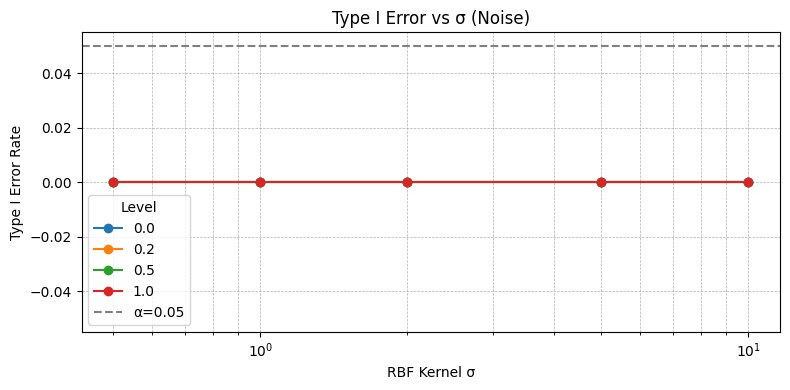

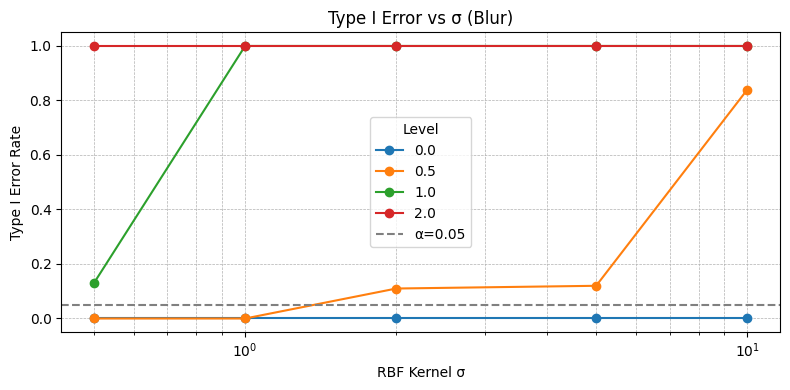

In [ ]:
sample_size = 50
sigmas = [0.5, 1, 2, 5, 10]
num_permutations = 300
noise_stds = [0.0, 0.2, 0.5, 1.0]
blur_sigmas = [0.0, 0.5, 1.0, 2.0]
n_trials = 10
# 运行系统实验
noise_res, blur_res = systematic_type1_experiments(
    sample_size, sigmas, num_permutations,
    noise_stds, blur_sigmas,
    n_trials=n_trials, alpha=0.05
)


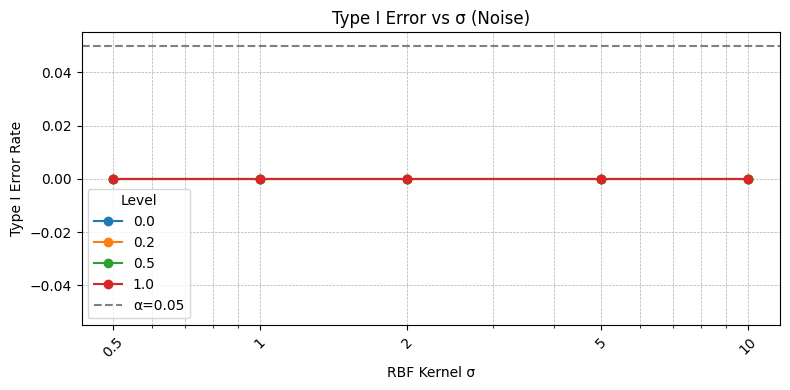

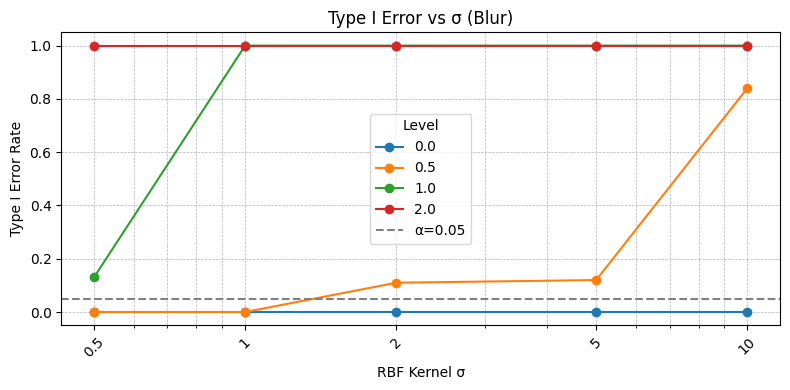

In [62]:
# 绘图
plot_type1_vs_sigma(sigmas, noise_stds, noise_res, title="Type I Error vs σ (Noise)")
plot_type1_vs_sigma(sigmas, blur_sigmas, blur_res, title="Type I Error vs σ (Blur)")
plt.show()

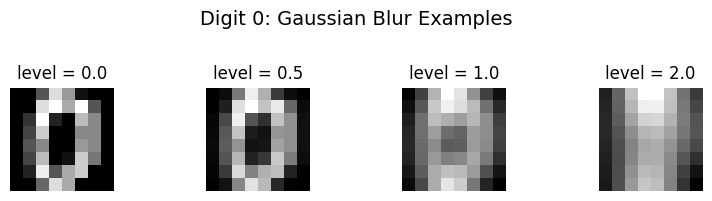

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from scipy.ndimage import gaussian_filter

def visualize_blur_example(digit: int, blur_sigmas: list):
    """
    从 sklearn 的 load_digits（8×8 手写数字）中选取一个 digit 类别的示例，
    对该图像应用不同程度的高斯模糊，并可视化结果。

    参数:
        digit (int): 手写数字类别 (0–9)
        blur_sigmas (list of float): 要测试的模糊程度 (高斯核 σ)
    """
    # 加载数据并找到第一个该类别的样本
    digits = load_digits()
    X, y = digits.data, digits.target
    idx = np.where(y == digit)[0][0]
    img = X[idx].reshape(8, 8)

    # 创建子图
    n = len(blur_sigmas)
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for ax, sigma in zip(axes, blur_sigmas):
        if sigma == 0.0:
            blurred = img
        else:
            blurred = gaussian_filter(img, sigma=sigma)
        ax.imshow(blurred, cmap='gray', interpolation='nearest')
        ax.set_title(f'level = {sigma}')
        ax.axis('off')

    fig.suptitle(f'Digit {digit}: Gaussian Blur Examples', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# 示例调用
visualize_blur_example(digit=0, blur_sigmas=[0.0, 0.5, 1.0, 2.0])

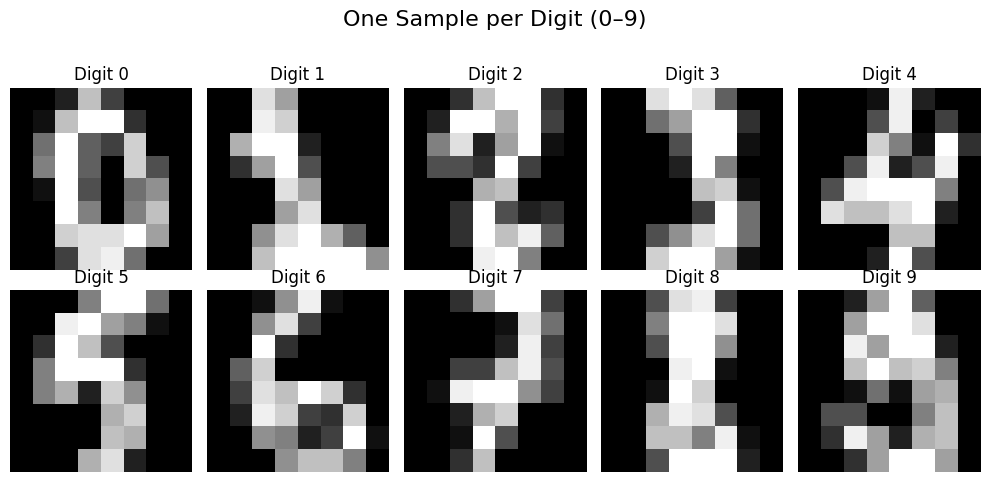

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def sample_and_plot_digits():
    """
    从 sklearn 8×8 数字数据集中，
    为每个数字 0-9 随机抽取一张样本并可视化。
    """
    digits = load_digits()
    X, y = digits.data, digits.target

    # 在每个类别中随机选择一个样本
    chosen_idxs = [np.random.choice(np.where(y == d)[0]) for d in range(10)]
    
    # 创建 2×5 网格显示
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for digit, ax in zip(range(10), axes.flatten()):
        img = X[chosen_idxs[digit]].reshape(8, 8)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_title(f"Digit {digit}")
        ax.axis('off')

    fig.suptitle("One Sample per Digit (0–9)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 执行示例
sample_and_plot_digits()